In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import imutils
%matplotlib inline

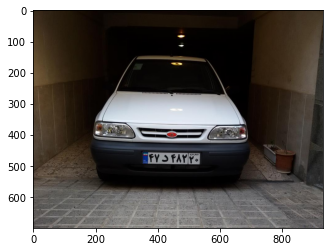

In [108]:
carplate_haar_cascade = cv2.CascadeClassifier('haarcascade_russian_plate_number.xml')

carplate_img = cv2.imread("test1/expo3358299/TamamrokhJolo.jpg")
carplate_img_rgb = cv2.cvtColor(carplate_img, cv2.COLOR_BGR2RGB)
plt.imshow(carplate_img_rgb)

In [109]:
import easyocr

import datetime
start = datetime.datetime.now()
reader = easyocr.Reader(['fa']) # need to run only once to load model into memory
result = reader.readtext(carplate_img_rgb, detail = 1)
end = datetime.datetime.now()

print(end - start)

CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.


0:00:21.796478


٤٨٢٢٠ ٥ ٤٧


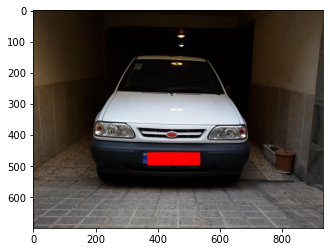

In [110]:
import numpy as np
import re

res = False
pattern = '\d*[\u0600-\u06FF]\d*'
prog = re.compile(pattern)

for i, r in enumerate(result):
    if prog.match(r[1]):
        print(r[1])
        pnt = np.array(r[0], np.int)
        pnt = pnt.reshape((-1, 1, 2))
        isClosed = True
        color = (255, 0, 0)
        thickness = 2

        carplate_img_rgb = cv2.fillPoly(carplate_img_rgb, [pnt], 255) 
                              #isClosed, color, thickness)
        plt.imshow(carplate_img_rgb)

In [111]:
logo_frame = carplate_img_rgb[carplate_img_rgb==[255,0,0]] 
logo_frame

array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)

In [112]:
pnt = []
for i, r in enumerate(result):
    pnt.append(r[0])

pnt = np.array(pnt, dtype=int)    
pnt = pnt.reshape(-1,2)
pnt

array([[367, 457],
       [537, 457],
       [537, 497],
       [367, 497]])

In [113]:
pnt1 = (min(pnt[:,1]), min(pnt[:,0]))
pnt2 = (max(pnt[:,1]), max(pnt[:,0]))

print(pnt1, pnt2)

(457, 367) (497, 537)


In [114]:
pnt1[0]

457

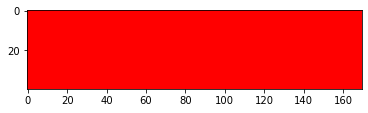

In [115]:
plt.imshow(carplate_img_rgb[pnt1[0]:pnt2[0], pnt1[1]:pnt2[1]])

In [116]:
dim = (pnt2[1]-pnt1[1], pnt2[0]-pnt1[0])

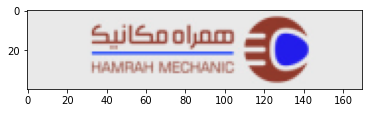

In [117]:
logo = cv2.imread("ham.jpg")
resized = cv2.resize(logo, dim, interpolation = cv2.INTER_AREA)
plt.imshow(resized)

In [118]:
carplate_img_rgb[pnt1[0]:pnt2[0], pnt1[1]:pnt2[1]] = resized

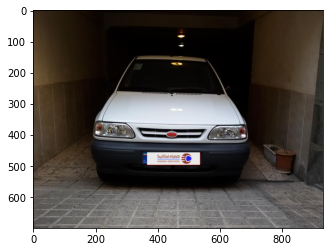

In [119]:
plt.imshow(carplate_img_rgb)

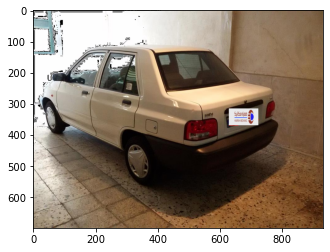

In [94]:
def carplate_detect(image):
    carplate_overlay = image.copy() 
    carplate_rects = carplate_haar_cascade.detectMultiScale(carplate_overlay,scaleFactor=1.1, minNeighbors=3)
    for x,y,w,h in carplate_rects: 
        print(x,y,w,h)
        cv2.rectangle(carplate_overlay, (x,y), (x+w,y+h), (0,0,0), -1) 
        
    return carplate_overlay
# Create function to retrieve only the car plate region itself
def carplate_extract(image):
    
    carplate_rects = carplate_haar_cascade.detectMultiScale(image,scaleFactor=1.1, minNeighbors=3)
    carplate_img = image[0:0,0:0]
    for x,y,w,h in carplate_rects: 
        carplate_img = image[y+15:y+h-10 ,x+15:x+w-20] # Adjusted to extract specific region of interest i.e. car license plate
        
    return carplate_img
# Enlarge image for further processing later on
def enlarge_img(image, scale_percent):
    width = int(image.shape[1] * scale_percent / 100)
    height = int(image.shape[0] * scale_percent / 100)
    dim = (width, height)
    resized_image = cv2.resize(image, dim, interpolation = cv2.INTER_AREA)
    return resized_image

detected_carplate_img = carplate_detect(carplate_img_rgb)
plt.imshow(detected_carplate_img)

In [47]:
# Display extracted car license plate image
carplate_extract_img = carplate_extract(carplate_img_rgb)
if carplate_extract_img.shape[0:2] != (0,0):
    carplate_extract_img = enlarge_img(carplate_extract_img, 150)
    # Convert image to grayscale
    carplate_extract_img_gray = cv2.cvtColor(carplate_extract_img, cv2.COLOR_RGB2GRAY)
    plt.axis('off') 
    # Apply median blur + grayscale
    carplate_extract_img_gray_blur = cv2.medianBlur(carplate_extract_img_gray,3) # Kernel size 3
    plt.axis('off') 
    plt.imshow(carplate_extract_img_gray_blur, cmap = 'gray');
else:
    print('can not any extract')

can not any extract


In [48]:
img = cv2.resize(carplate_img, (620,480) )
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) #convert to grey scale
gray = cv2.bilateralFilter(gray, 13, 15, 15)
edged = cv2.Canny(gray, 30, 200) #Perform Edge detection

contours=cv2.findContours(edged.copy(),cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
contours = imutils.grab_contours(contours)
contours = sorted(contours,key=cv2.contourArea, reverse = True)[:10]
screenCnt = None
for c in contours: 
    print('c')
    peri = cv2.arcLength(c, True)
    approx = cv2.approxPolyDP(c, 0.018 * peri, True)
 
    if len(approx) == 4:
        screenCnt = approx
        break
        
if screenCnt is None:
    detected = 0
    print ("No contour detected")
else:
    detected = 1
    print ("OK contour detected")
    
    cv2.drawContours(img, [screenCnt], -1, (0, 0, 255), 3)

    mask = np.zeros(gray.shape,np.uint8)
    new_image = cv2.drawContours(mask,[screenCnt],0,255,-1,)
    new_image = cv2.bitwise_and(img,img,mask=mask)
    
    (x, y) = np.where(mask == 255)
    (topx, topy) = (np.min(x), np.min(y))
    (bottomx, bottomy) = (np.max(x), np.max(y))
    Cropped = gray[topx:bottomx+1, topy:bottomy+1]
    img = cv2.resize(img,(500,300))
    Cropped = cv2.resize(Cropped,(400,200))

    cv2.imshow('car',img)
    cv2.imshow('Cropped',Cropped)
    cv2.drawContours(img, [screenCnt], -1, (0, 0, 255), -1)
    plt.imshow(img)

c
c
c
c
c
c
c
c
c
c
No contour detected


In [49]:
if detected:
    carplate_extract_img_gray = cv2.cvtColor(new_image, cv2.COLOR_RGB2GRAY)
    plt.axis('off') 
    plt.imshow(carplate_extract_img_gray, cmap = 'gray');
    # Apply median blur + grayscale
    carplate_extract_img_gray_blur = cv2.medianBlur(carplate_extract_img_gray,3) # Kernel size 3
    plt.axis('off') 
    plt.imshow(carplate_extract_img_gray_blur, cmap = 'gray');

In [113]:
t = end - start
t

datetime.timedelta(seconds=21, microseconds=614587)

In [114]:
for i, r in enumerate(result):
    print(r)

[[[753.7230723179239, 440.70615062254666], [826.4691474499912, 403.85304736765835], [843.2769276820761, 438.29384937745334], [770.5308525500088, 475.14695263234165]], '٣آد', 0.09263352740115773]


In [120]:
pnt

array([[[753, 440]],

       [[826, 403]],

       [[843, 438]],

       [[770, 475]]])

In [31]:
lx = 0
ly = 0
for i, r in enumerate(result[-1][0]):
    lx = max(lx, int(r[0]))
    ly = max(lx, int(r[1]))
    
    

w = max(lx, ly)
h = min(lx, ly)
dim = (w,h)
print(f'dim = {dim}')

dim = (466, 228)


In [26]:
logo.shape

(70, 300, 3)

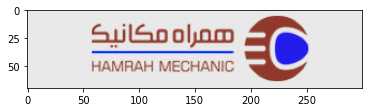

In [25]:
logo = cv2.imread("ham.jpg")
plt.imshow(logo)

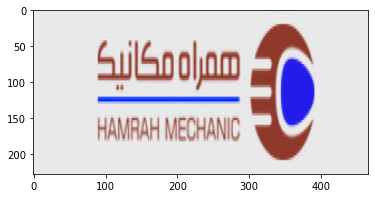

In [33]:
resized = cv2.resize(logo, dim, interpolation = cv2.INTER_AREA)
plt.imshow(resized)

In [34]:
carplate_img_rgb

array([[[ 53,  34,  19],
        [ 95,  76,  61],
        [ 81,  62,  47],
        ...,
        [ 15,  17,  12],
        [ 16,  18,  13],
        [ 17,  19,  14]],

       [[ 88,  69,  54],
        [132, 113,  98],
        [120, 101,  86],
        ...,
        [ 22,  24,  19],
        [ 22,  24,  19],
        [ 23,  25,  20]],

       [[ 82,  63,  48],
        [130, 111,  96],
        [121, 102,  87],
        ...,
        [ 20,  22,  17],
        [ 21,  23,  18],
        [ 22,  24,  19]],

       ...,

       [[ 68,  61,  53],
        [111, 104,  96],
        [ 99,  92,  84],
        ...,
        [ 79,  56,  25],
        [ 82,  59,  28],
        [ 86,  63,  32]],

       [[ 66,  59,  51],
        [108, 101,  93],
        [ 92,  85,  77],
        ...,
        [ 81,  58,  26],
        [ 85,  62,  30],
        [ 89,  66,  34]],

       [[ 65,  58,  50],
        [103,  96,  88],
        [ 81,  74,  66],
        ...,
        [ 88,  65,  33],
        [ 90,  67,  35],
        [ 94,  71,  39]]

# Regtangle mode

In [22]:
start, end = result[-1][0][2], result[-1][0][0]
(startX, startY, endX, endY) = start[0], start[1], end[0], end[1]
print((startX, startY, endX, endY))

(209.55828472590844, 521.968734060585, 87.44171527409158, 423.031265939415)


209 521 87 423


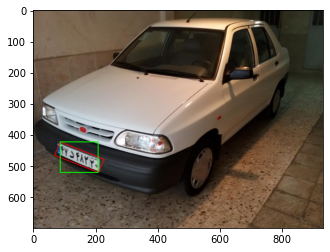

In [31]:
startX = int(startX)
startY = int(startY)
endX = int(endX)
endY = int(endY)

print(startX,startY,endX,endY)
# cv2.rectangle(img=carplate_img_rgb, pt1=c[0], pt2=c[1], color=(0,0,0), thickness=-1) 
cv2.rectangle(carplate_img_rgb, (startX, startY), (endX, endY), (0, 255, 0), 2)
plt.imshow(carplate_img_rgb)

In [26]:
# # Display the text extracted from the car plate
# import pytesseract
# 
# # Set tesseract path to where the tesseract exe file is located (Edit this path accordingly based on your own settings)
# pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR\tesseract.exe'
# 
# print(pytesseract.image_to_string(carplate_extract_img_gray_blur))
#                                   # config = f'--psm 8 --oem 3 -c tessedit_char_whitelist=ABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789'))